In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

from GenerateInput import generate_input
from LifeStepFunctions import life_step_for_tensors
from CostumisedLayers import *


In [2]:
x_train = list()
for x in product([0,1], repeat=9):
    x1, x2, x3, x4, x5, x6, x7, x8, x9 = x
    sample = [[x1, x2, x3], [x4, x5, x6], [x7, x8, x9]]
    x_train.append(sample)

x_train = tf.constant(np.array(x_train), dtype='float32')
y_train = life_step_for_tensors(x_train)

In [3]:
life_step_for_tensors(tf.constant(np.array([[[1,0,0],[0,1,0],[0,0,0]]]), dtype=float))

&lt;tf.Tensor: id=68, shape=(1, 1, 1), dtype=float32, numpy=array([[[0.]]], dtype=float32)&gt;

In [4]:
model_3x3 = tf.keras.models.Sequential()
model_3x3.add(tf.keras.layers.Flatten())
model_3x3.add(tf.keras.layers.Dense(2, activation='relu'))
model_3x3.add(tf.keras.layers.Dense(6, activation='relu'))
model_3x3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [8]:
model_3x3.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

model_3x3.fit(x_train, y_train, epochs=1, batch_size=10)

Train on 512 samples
512/512 [==============================] - 1s 2ms/sample - loss: 6.0628e-04 - accuracy: 1.0000


&lt;tensorflow.python.keras.callbacks.History at 0x25f97ddef08&gt;

In [9]:
y_pred = (model_3x3.call(x_train) > 0.5)
y_pred = tf.cast(y_pred, dtype="float32")

y_pred = tf.reshape(y_pred, shape=(16,32))
y_train = tf.reshape(y_train, shape=(16,32))

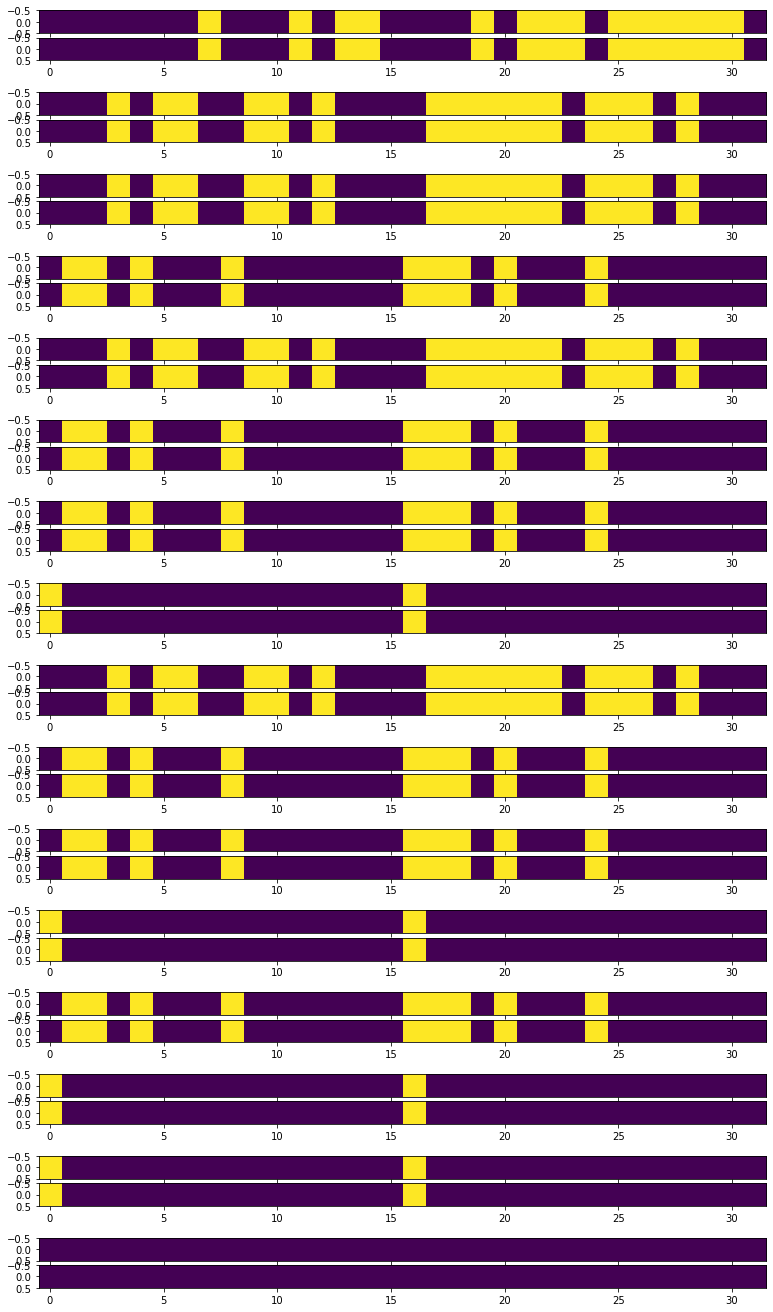

In [10]:
plt.figure(figsize=(16, 24))
for i in range(len(y_pred)):
    plt.subplot(48, 1, i+1 + 2*i)
    plt.imshow([y_pred[i]])
    
    plt.subplot(48, 1, i+2+ 2*(i))
    
    plt.imshow([y_train[i]])
    

In [72]:
class MyModel(tf.keras.models.Model):
    def __init__(self, grid_size):
        super(MyModel, self).__init__()
        self.m = grid_size[0]
        self.n = grid_size[1]
    
    def call(self, x):

        grid = tf.Variable(tf.zeros(shape=x.shape), dtype='float32')

        # find values for the cells in the interior
        for i in range(1,self.m-1):
            for j in range(1,self.n-1):
                grid_3x3 = x[:,i-1:i+2, j-1:j+2]
                X = model_3x3.call(grid_3x3)
                X = tf.reshape(X, shape=(-1,1,1))
                grid[:,i:i+1,j:j+1].assign(X)

        # find values for the boundsry cells
        for i in range(1, self.m-1):
            grid_3x3 = tf.Variable(tf.zeros(shape=(x.shape[0],3,3)))
            grid_3x3[:,:,1:].assign(x[:,i-1:i+2,:2])
            grid_3x3[:,:,0:1].assign(x[:,i-1:i+2,-1:])
            
            X = model_3x3.call(grid_3x3)
            X = tf.reshape(X, shape=(-1,1,1))
            grid[:,i:i+1,0:1].assign(X)
        
        for i in range(1, self.m-1):
            grid_3x3 = tf.Variable(tf.zeros(shape=(x.shape[0],3,3)))
            grid_3x3[:,:,:2].assign(x[:,i-1:i+2,-2:])
            grid_3x3[:,:,-1:].assign(x[:,i-1:i+2,0:1])
            
            X = model_3x3.call(grid_3x3)
            X = tf.reshape(X, shape=(-1,1,1))
            grid[:,i:i+1,-1:].assign(X)

        for j in range(1, self.n-1):
            grid_3x3 = tf.Variable(tf.zeros(shape=(x.shape[0],3,3)))
            grid_3x3[:,1:,:].assign(x[:,:2,j-1:j+2])
            grid_3x3[:,0:1,:].assign(x[:,-1:,j-1:j+2])
            
            X = model_3x3.call(grid_3x3)
            X = tf.reshape(X, shape=(-1,1,1))
            grid[:,0:1,j:j+1].assign(X)

        for j in range(1, self.n-1):
            grid_3x3 = tf.Variable(tf.zeros(shape=(x.shape[0],3,3)))
            grid_3x3[:,2:,:].assign(x[:,:1,j-1:j+2])
            grid_3x3[:,:2,:].assign(x[:,-2:,j-1:j+2])
            
            X = model_3x3.call(grid_3x3)
            X = tf.reshape(X, shape=(-1,1,1))
            grid[:,-1:,j:j+1].assign(X)

        # point (0,0)
        grid_3x3 = tf.Variable(tf.zeros(shape=(x.shape[0],3,3)))
        grid_3x3[:,1:,1:].assign(x[:,:2,:2])
        grid_3x3[:,:1,1:].assign(x[:,-1:,0:2])
        grid_3x3[:,1:,:1].assign(x[:,:2,-1:])
        grid_3x3[:,:1,:1].assign(x[:,-1:,-1:])

        X = model_3x3.call(grid_3x3)
        X = tf.reshape(X, shape=(-1,1,1))
        grid[:,0:1,0:1].assign(X)

        # point (0,-1)
        grid_3x3 = tf.Variable(tf.zeros(shape=(x.shape[0],3,3)))
        grid_3x3[:,1:,:2].assign(x[:,:2,-2:])
        grid_3x3[:,:1,:2].assign(x[:,-1:,-2:])
        grid_3x3[:,1:,-1:].assign(x[:,:2,:1])
        grid_3x3[:,:1,-1:].assign(x[:,-1:,0:1])
        
        X = model_3x3.call(grid_3x3)
        X = tf.reshape(X, shape=(-1,1,1))
        grid[:,:1,-1:].assign(X)

        # point (-1, 0)
        grid_3x3 = tf.Variable(tf.zeros(shape=(x.shape[0],3,3)))
        grid_3x3[:,:2,-2:].assign(x[:,-2:,:2])
        grid_3x3[:,:2,:1].assign(x[:,-2:,-1:])
        grid_3x3[:,2:,-2:].assign(x[:,:1,:2])
        grid_3x3[:,-1:,:1].assign(x[:,:1,-1:])
        
        X = model_3x3.call(grid_3x3)
        X = tf.reshape(X, shape=(-1,1,1))
        grid[:,-1:,:1].assign(X)

        # point (-1,-1)
        grid_3x3 = tf.Variable(tf.zeros(shape=(x.shape[0],3,3)))
        grid_3x3[:,:2,:2].assign(x[:,-2:,-2:])
        grid_3x3[:,:2,-1:].assign(x[:,-2:,:1])
        grid_3x3[:,-1:,:2].assign(x[:,:1,-2:])
        grid_3x3[:,-1:,-1:].assign(x[:,:1,:1])
        
        X = model_3x3.call(grid_3x3)
        X = tf.reshape(X, shape=(-1,1,1))
        grid[:,-1:,-1:].assign(X)
        return grid

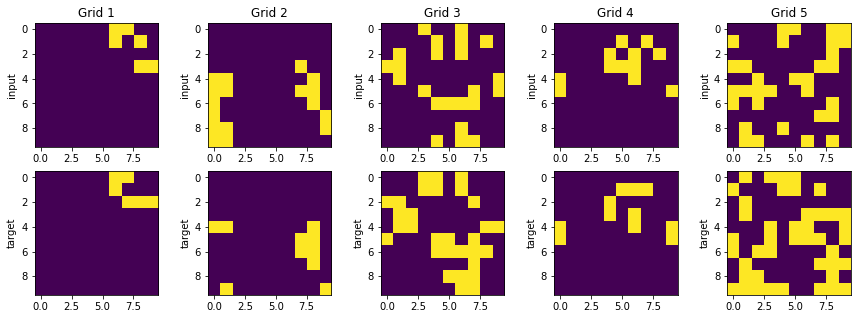

In [83]:
x, y = generate_input(trials=8, grid_shape=(10,10),steps_before_generating_output=2)


plt.figure(figsize=(3*len(x), 5))
for i in range(len(x)):
    plt.subplot(2, len(x), i+1)
    plt.title('Grid ' + str(i+1))
    plt.imshow(x[i])
    plt.ylabel('input')
    plt.subplot(2, len(x), len(x)+i+1)
    plt.imshow(y[i])
    plt.ylabel('target')
    

In [84]:
aaa =MyModel(grid_size=(10,10))
y_grid_pred = aaa.call(x)

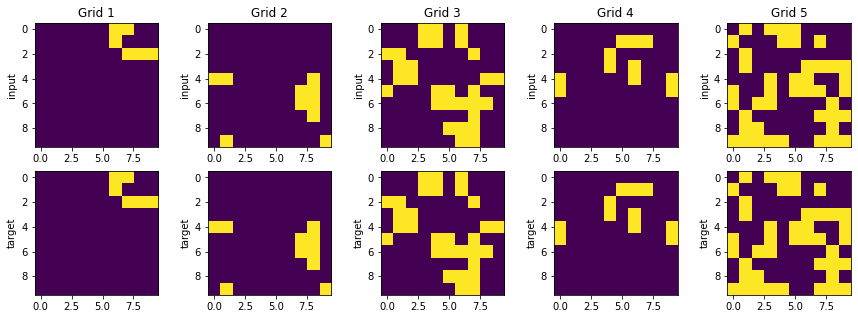

In [85]:
y_grid_pred = (y_grid_pred > 0.5)
y_grid_pred = tf.cast(y_grid_pred, dtype="float32")

plt.figure(figsize=(3*len(x), 5))
for i in range(len(y)):
    plt.subplot(2, len(y), i+1)
    plt.title('Grid ' + str(i+1))
    plt.imshow(y_grid_pred[i])
    plt.ylabel('input')
    plt.subplot(2, len(y), len(y)+i+1)
    plt.imshow(y[i])
    plt.ylabel('target')